In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from skimage.draw import line

%matplotlib inline

In [2]:
# load dem
filename = "brooklyn10m.dem"
demdata = gdal.Open(filename)
demarray = np.array(demdata.GetRasterBand(1).ReadAsArray())
print("shape", demarray.shape)
print("min", demarray.min(), "\nmax", demarray.max())

shape (1403, 1073)
min -32767.0 
max 66.0


In [3]:
indices = np.where(demarray == demarray.max())
ymax, xmax = indices[0][0], indices[1][0]
print("The highest point is", demarray[ymax][xmax], "at pixel location", [ymax, xmax])

indices = np.where(demarray == demarray.min())
ymin, xmin = indices[0][0], indices[1][0]
print("The lowest point is", demarray[ymin][xmin], "at pixel location", [ymin, xmin])

The highest point is 66.0 at pixel location [1037, 107]
The lowest point is -32767.0 at pixel location [0, 0]


In [4]:
print(demarray[ymax-3:ymax+3, xmax-3:xmax+3])

[[58.9 60.7 62.2 63.4 64.3 64.8]
 [60.5 62.2 64.  64.5 65.  65.4]
 [61.7 63.8 64.7 65.3 65.7 65.1]
 [62.8 64.7 65.5 66.  65.6 65. ]
 [63.1 64.7 65.6 65.9 65.8 65.4]
 [62.3 63.9 64.6 64.8 64.9 64.8]]


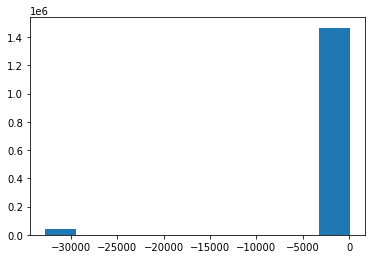

In [5]:
plt.hist(demarray.flatten())
plt.show()

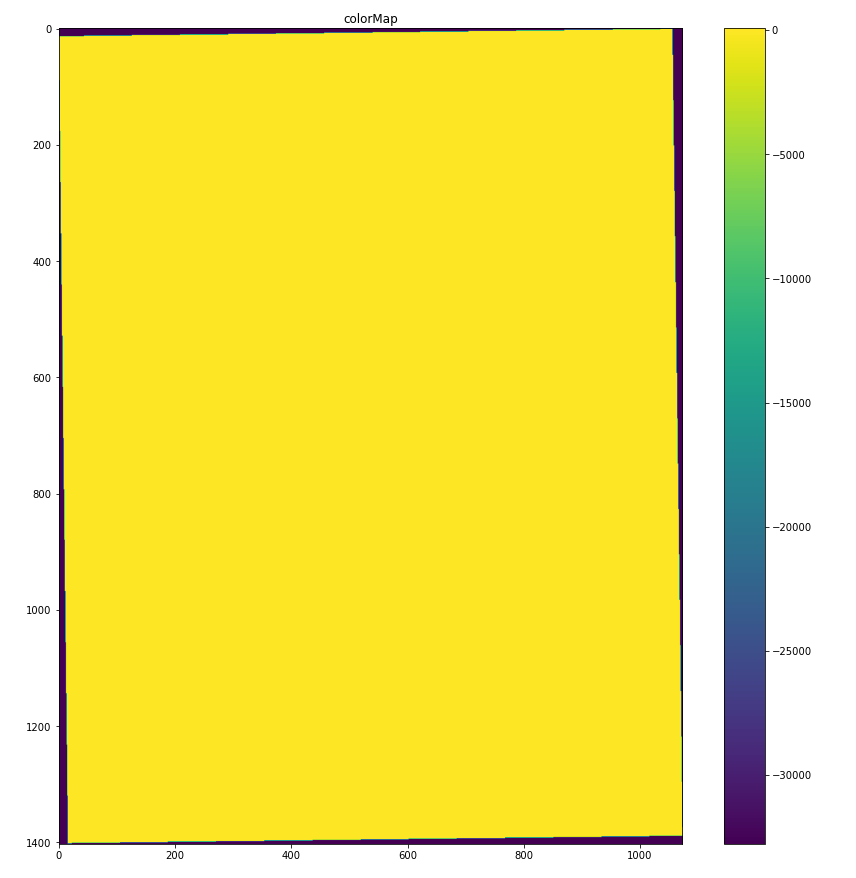

In [6]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(demarray)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical', ax=ax)
plt.show()

In [7]:
# correct min elevation?
min_elevation = -1

i2 = np.where(demarray < min_elevation)
demarray = demarray.copy()
demarray[i2] = min_elevation
print(demarray.min(), demarray.max())

-1.0 66.0


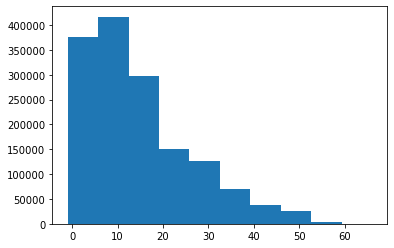

In [8]:
plt.hist(demarray.flatten())
plt.show()

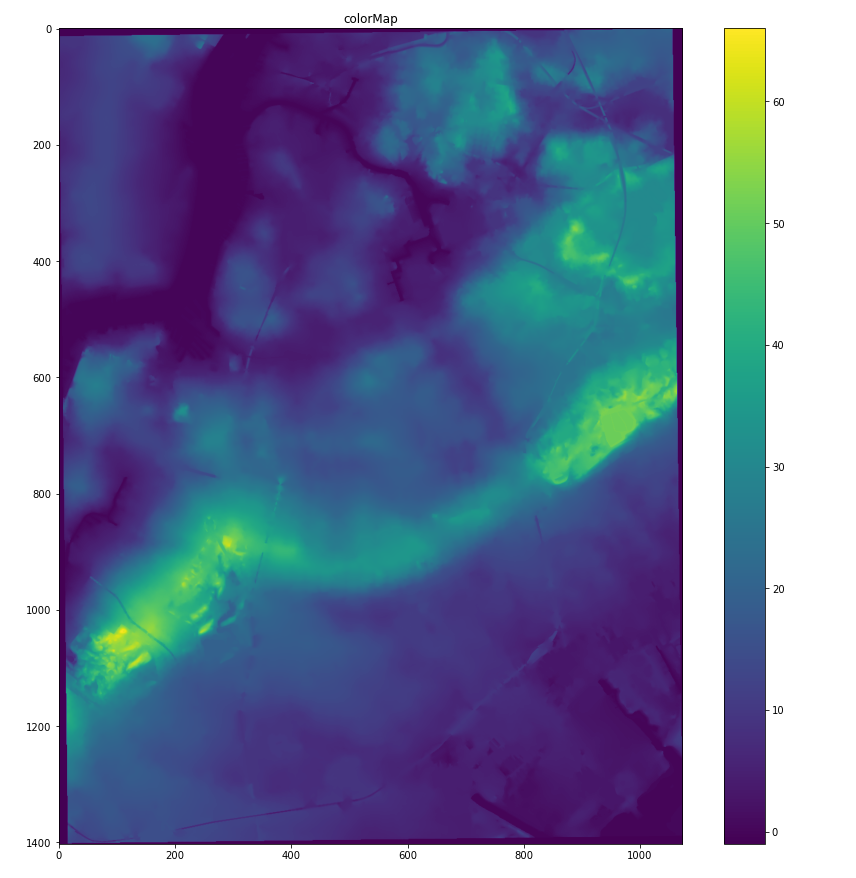

In [9]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(demarray)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical', ax=ax)
plt.show()

In [10]:
####################
# CLEAN UP EDGES
####################

# make copy of dem to edit
dem2 = demarray.copy()

# go through image
for row in range(demarray.shape[0]):
    if row%100==0:
        print(row, '/', demarray.shape[0])
    for col in range(demarray.shape[1]):
        #if col%100==0:
        #    print(col)
        # if pixel value is < 0, set it to closest non-negative pixel value (take average value if more than 1)
        if demarray[row, col] < 0:
            fixed = False
            dist = 1
            while not fixed:
                # get min/max rows/cols for values dist from the pixel
                minrow = row-dist
                if minrow < 0:
                    minrow = 0
                maxrow = row+dist
                if maxrow > demarray.shape[0]:
                    maxrow = demarray.shape[0]
                mincol = col-dist
                if mincol < 0:
                    mincol = 0
                maxcol = col+dist
                if maxcol >= demarray.shape[1]:
                    maxcol = demarray.shape[1]
                
                # get matrix of size dist around the pixel
                m = demarray[minrow:maxrow, mincol:maxcol]
                
                # find all non-negative values in the matrix m
                nonnegs = []
                for mrow in range(m.shape[0]):
                    for mcol in range(m.shape[1]):
                        if m[mrow, mcol] >= 0:
                            nonnegs.append(m[mrow, mcol])
                # if nonnegs, get average and set value to it
                if len(nonnegs):
                    avg = np.mean(nonnegs)
                    dem2[row, col] = round(avg, 1)
                    fixed = True
                # if no nonnegs, increase distance and continue
                else:
                    dist += 1

0 / 1403
100 / 1403
200 / 1403
300 / 1403
400 / 1403
500 / 1403
600 / 1403
700 / 1403
800 / 1403
900 / 1403
1000 / 1403
1100 / 1403
1200 / 1403
1300 / 1403
1400 / 1403


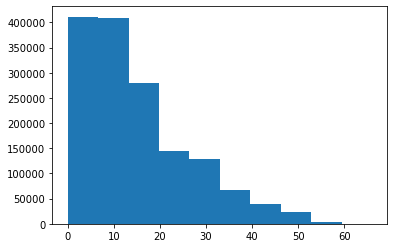

In [11]:
plt.hist(dem2.flatten())
plt.show()

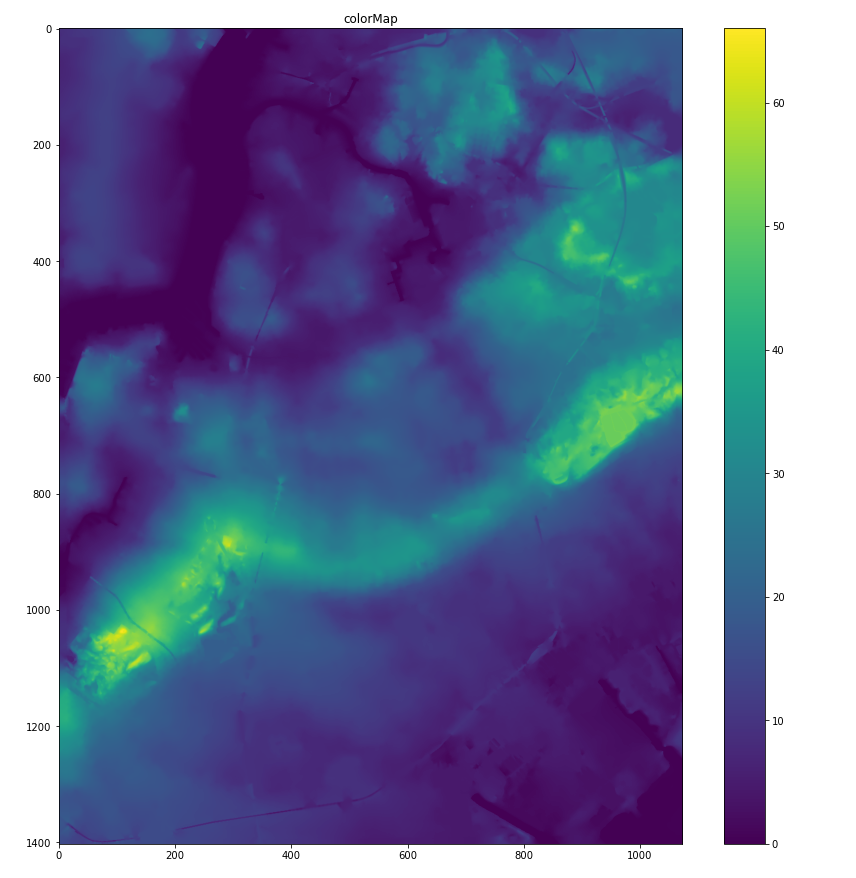

In [12]:
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(dem2)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical', ax=ax)
plt.show()

In [13]:
# try horizon to right of middle pixel value
start = [700, 500]
# NOTE: we have to add 2 below because it can find sharp angles with just small differences in the first 10m, 
#    plus most images are probably taken at eye level, over a meter higher
start_elev = dem2[start[0], start[1]] + 2
print('start height', start_elev)
maxtheta = -np.pi/4 # init to lowest
peak = ""

# go through each pixel to the right
i = 1
for col in range(start[1]+1, dem2.shape[1]):
    elev = dem2[start[0], col]
    #print(elev)
    # find theta with arctan(opposite/adjacent)
    # opposite is just elev-start_elev
    opp = (elev-start_elev)
    # adjacent length is 10m per pixel, which is 10x height, so multiply col by 10 to match height
    # NOTE: check if this step is skippable. maybe adj pixel gsd is arbitrary and can skip multiplying by 10
    adj = (col-start[1])*10
    newtheta = np.arctan(opp/adj)
    i+=1
    if newtheta > maxtheta:
        maxtheta = newtheta
        peak = str(opp+start_elev)+" meters and "+str(round(maxtheta*180/np.pi, 4))+" degrees at position "+str([start[0], col])
print(peak)
print(i)

start height 20.0
51.5 meters and 0.4187 degrees at position [700, 931]
573


In [14]:
#https://stackoverflow.com/questions/7878398/how-to-extract-an-arbitrary-line-of-values-from-a-numpy-array

# make a line with "num" points...
# NOTE: can speed this up by rounding to nearest pixels... a little jagged but probably a lot faster
x0, y0 = start[1], start[0] # these are in pixel coordinates
x1, y1 = dem2.shape[1], start[0]
num = int(np.hypot(x1-x0, y1-y0)) # approx num of pixels from point to edge of image
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

zi = scipy.ndimage.map_coordinates(dem2, np.vstack((y,x)))
#zi += start_elev - 1.5
#print(zi+start_elev)

# start 2m higher to prevent small changes from nearby pixels having the highest thetas
start_elev = dem2[start[0], start[1]] + 2
print('start height', start_elev)
maxtheta = -np.pi/4 # init to lowest
peak = ""

# go through each pixel to the right
for col,elev in enumerate(zi):
    # skip starting pixel or get divide my zero errors in arctan
    if col > 0:
        #print(col,elev)
        # find theta with arctan(opposite/adjacent)
        # opposite is just elev-start_elev
        opp = elev-start_elev
        # adjacent length is 10m per pixel, which is 10x height, so multiply col by 10 to match height
        # NOTE: check if this step is skippable. maybe adj pixel gsd is arbitrary and can skip multiplying by 10
        adj = col*10
        newtheta = np.arctan(opp/adj)
        #print(newtheta)
        if newtheta > maxtheta:
            maxtheta = newtheta
            peak = str(opp+start_elev)+" meters and "+str(round(maxtheta*180/np.pi, 4))+" degrees at position "+str([start[0], start[1]+col])
print(peak)
print(num)

start height 20.0
51.49637985229492 meters and 0.4197 degrees at position [700, 930]
573


In [15]:
######################################
# GET HORIZON IN ALL 360 DIRECTIONS
######################################

# TODO: because of earth curvature, lose ~8 inches every mile. subtract this from elevation calculations

start = [700, 600]
horizon_locations = []
horizon_elevations = []

for direction in range(0,360,1):
    if direction%45==0:
        print(direction)
    # between 0-45 degrees
    #if direction >= 0 and direction <= 45:
    radians = np.deg2rad(direction)
    if direction >= 0 and direction < 90:
        adj = dem2.shape[1]-start[1]
        opp = np.tan(radians)*adj # tan positive in quadrant 1
    elif direction > 90 and direction < 180:
        adj = -start[1]
        opp = np.tan(radians)*adj # tan negative in quadrant 2
    elif direction >= 180 and direction < 270:
        adj = -start[1]
        opp = np.tan(radians)*adj # tan positive in quadrant 3
    elif direction > 270: # and direction < 360:
        adj = dem2.shape[1]-start[1]
        opp = np.tan(radians)*adj # tan negative in quadrant 4
    # tan(90 degrees) and tan(270 degrees) are infinity
    elif direction == 90:
        adj = 0
        opp = start[0]
    elif direction == 270:
        adj = 0
        opp = start[0]-dem2.shape[0]

    #https://stackoverflow.com/questions/7878398/how-to-extract-an-arbitrary-line-of-values-from-a-numpy-array
    #https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    # can switch below to skimage.draw.line() for fast rows/cols. can use line_aa() for anti-aliasing to make less jagged.
    
    # make a line with "num" points...
    x0, y0 = start[1], start[0] # these are in pixel coordinates
    x1, y1 = start[1]+adj, start[0]-opp # NOTE: y values are reversed because rows start at the top
    num = int(np.hypot(x1-x0, y1-y0)) # approx num of pixels from point to edge of image
    x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

    # check for out of bounds before mapping (NOTE: don't try to do this earlier, do it here!)
    indx = 0
    while indx < len(x):
        if x[indx] < 0 or x[indx] >= dem2.shape[1]:
            break
        else:
            indx += 1
    indy = 0
    while indy < len(y):
        if y[indy] < 0 or y[indy] >= dem2.shape[0]:
            break
        else:
            indy += 1
    # always take the smaller
    if indx <= indy:
        x = x[:indx]
        y = y[:indx]
    else:
        x = x[:indy]
        y = y[:indy]

    # now map!
    zi = scipy.ndimage.map_coordinates(dem2, np.vstack((y,x)))
    
    # start 2m higher to prevent small changes from nearby pixels having the highest thetas
    #    plus many images are taken at eye level
    start_elev = dem2[start[0], start[1]] + 2
    #print('start height', start_elev)
    maxtheta = -np.pi/4 # init to lowest
    highest_location = start.copy()
    highest_elevation = -999999.

    # go through each pixel to the right
    for dist_along_hypot,elev in enumerate(zi):
        if dist_along_hypot > 0:
            #print(dist_along_hypot,elev)
            # find theta with arctan(opposite/adjacent)
            # opposite is just elev-start_elev
            opp = elev-start_elev
            # adjacent length is 10m per pixel, which is 10x height, so multiply col by 10 to match height
            # NOTE: check if this step is skippable. maybe adj pixel gsd is arbitrary and can skip multiplying by 10
            #       bc all angles will be off, but off proportionately. and all we need is the biggest angle anyway.
            #       we don't need that biggest angle to be accurate (at least for now)
            adj = dist_along_hypot*10
            newtheta = np.arctan(opp/adj)

            # biggest angle is the horizon
            if newtheta > maxtheta:
                maxtheta = newtheta
                # calc row and col position given angle and hypotenuse. SOHCAHTOA
                rows_above_start = np.sin(radians)*dist_along_hypot
                cols_right_of_start = np.cos(radians)*dist_along_hypot
                highest_location = [start[0]-rows_above_start, start[1]+cols_right_of_start]
                highest_elevation = elev
                
    horizon_locations.append(highest_location)
    horizon_elevations.append(highest_elevation)


0
45
90
135
180
225
270
315


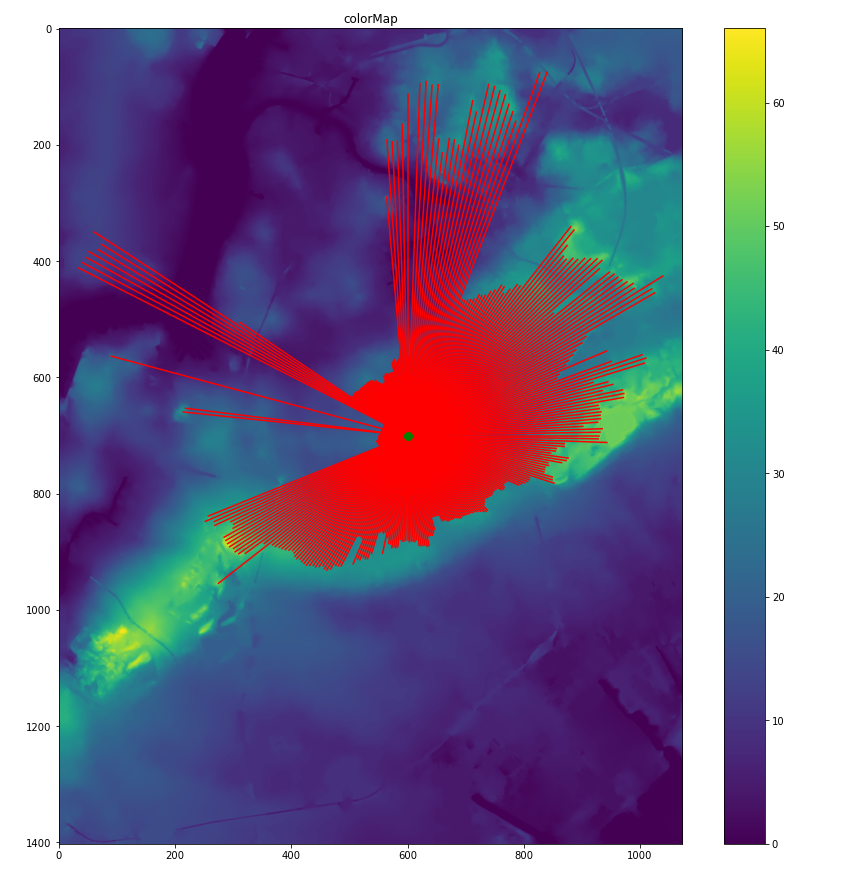

In [16]:
rows, cols = zip(*horizon_locations)

fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(dem2)
for i in range(len(cols)):
    rows2 = [start[0], rows[i]]
    cols2 = [start[1], cols[i]]
    plt.plot(cols2, rows2, 'r-')
    #plt.plot(start[1], start[0], 'ro') # NOTE: expects x,y not row,col so reverse them
    #plt.plot(cols,rows, 'rx-') # NOTE: expects x,y not row,col so reverse them

# start point in green
plt.plot([start[1]], [start[0]], 'go', markersize=8)

ax.set_aspect('equal')
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical', ax=ax)
plt.show()

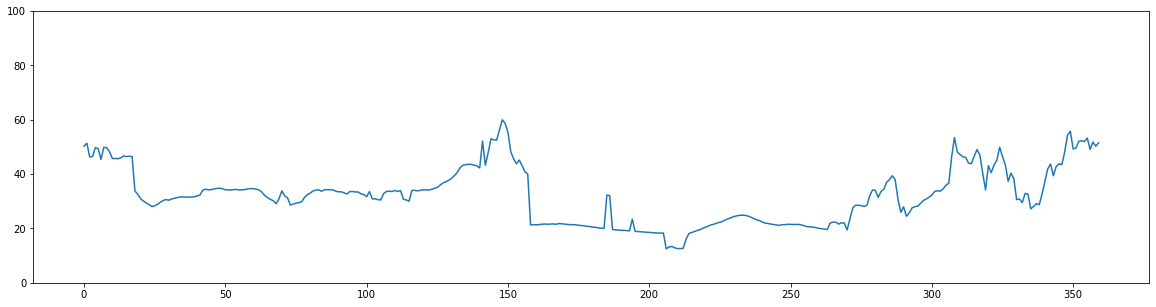

In [23]:
h2 = horizon_elevations.copy()
h2.reverse()
fig = plt.figure(figsize=(20,5))
plt.plot(h2)
plt.ylim(0,100)
plt.show()

In [ ]:
# for encoded horizon template matching/LSH searches, compare derivative of elevations (encoded)
#      so you don't have to get the initial elevation correct?